In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import math
import random 

# Import data
## called APC frameshift and stop_gained mutations from primary CRC genomes in v8 of 100kGP
all_stops_frame=pd.read_csv('canonical_frame_stops_SUMMARY.csv',sep='\t')

## Cornish et al (22) summary results
All_landscape= pd.read_csv('Landscape_data/WNT_CRC_v8_2023_candidate_genes_194_oncogenic_matrix_filtered_by_patient.csv',sep="\t")
ids_keys=pd.read_csv('Landscape_data/crc_polypy_preferred_paths.tsv',sep="\t")


In [2]:
# Match ids to classify samples by MSS, MSI and POLE following Cornish et al (22)

keys_lan=np.asarray(All_landscape['tumour_sample_platekey'])
keys=np.asarray(ids_keys['somatic_platekey'])
ids=np.asarray(ids_keys['participant_id'])
ids_lan=np.zeros(len(keys_lan))
for i in np.arange(len(keys_lan)):
    m=keys_lan[i]
    match=np.where(keys==m)[0]
    if len(match)>0:
        match=np.where(keys==m)[0][0]
        ids_lan[i]=ids[match]
    else: 
        ids_lan[i]=0
All_landscape['Participant_ID']=ids_lan
mss_ids=All_landscape['Participant_ID'][All_landscape['subtype']=='MSS']
pole_ids=All_landscape['Participant_ID'][All_landscape['subtype']=='POL']
msi_ids=All_landscape['Participant_ID'][All_landscape['subtype']=='MSI']

In [3]:
# Analyse called stop-gained and frameshifts data

## find number of samples
unique_ids=np.unique(all_stops_frame['#Participant_id'])
print('Number of samples, n=', len(unique_ids))

# remove downstream SAMP
protein_position=[]
for i in np.arange(len(all_stops_frame)):
    
    if len(all_stops_frame['Protein_position'][i])>8:
        protein_position.append(int(all_stops_frame['Protein_position'][i][0:4]))
    elif len(all_stops_frame['Protein_position'][i])>5:
        protein_position.append(int(all_stops_frame['Protein_position'][i][0:3]))
    elif len(all_stops_frame['Protein_position'][i])>4:
        protein_position.append(int(all_stops_frame['Protein_position'][i][0:2]))
    else:
        protein_position.append(int(all_stops_frame['Protein_position'][i]))
all_stops_frame['Position']=protein_position

A=len(all_stops_frame)
all_stops_frame=all_stops_frame[all_stops_frame['Position']<1605]
print('Remove alterations after SAMP, n=',A-len(all_stops_frame) )

# unique Patient Ids
unique_ids=np.unique(all_stops_frame['#Participant_id'])
print('Total samples considered, n=', len(unique_ids))


# stop_gained versus frameshift
cons=[]
for i in all_stops_frame['Consequence']:
    if i in [ 'stop_gained', 'stop_gained-frameshift_variant', 'stop_gained-inframe_deletion',     'stop_gained-protein_altering_variant',      'stop_gained-splice_region_variant']:
        cons.append('stop_gained')
    if i in ['frameshift_variant','frameshift_variant-splice_region_variant',       'frameshift_variant-stop_lost']:
        cons.append('frameshift')
all_stops_frame['Type']=cons

print('Total Stop gained, n=', sum(all_stops_frame['Consequence'].isin( [ 'stop_gained', 'stop_gained-frameshift_variant', 'stop_gained-inframe_deletion',     'stop_gained-protein_altering_variant',      'stop_gained-splice_region_variant'])))
print('Total Frameshift, n=', sum(all_stops_frame['Consequence'].isin(['frameshift_variant','frameshift_variant-splice_region_variant',       'frameshift_variant-stop_lost'])))
print('Stop gained / Frameshift, n=', sum(all_stops_frame['Consequence'].isin( [ 'stop_gained', 'stop_gained-frameshift_variant', 'stop_gained-inframe_deletion',     'stop_gained-protein_altering_variant',      'stop_gained-splice_region_variant']))/  sum(all_stops_frame['Consequence'].isin(['frameshift_variant','frameshift_variant-splice_region_variant',       'frameshift_variant-stop_lost'])))

Number of samples, n= 1885
Remove alterations after SAMP, n= 42
Total samples considered, n= 1867
Total Stop gained, n= 1654
Total Frameshift, n= 1182
Stop gained / Frameshift, n= 1.3993231810490694


MSS samples n= 1637 , MSS stop-gained mutations n= 1206  MSS frameshift mutations n= 831


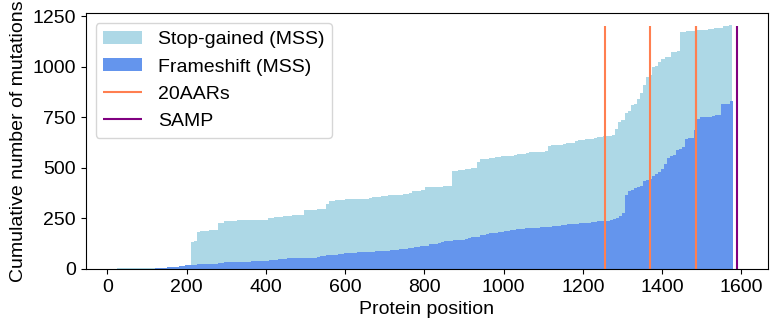

In [4]:
# Plot cumulative distribution of mutations in MSS samples

all_stops_frame_mss=all_stops_frame[all_stops_frame['#Participant_id'].isin(mss_ids)]
all_frame=all_stops_frame_mss[all_stops_frame_mss['Type']=='frameshift']
all_stops=all_stops_frame_mss[all_stops_frame_mss['Type']=='stop_gained']

print('MSS samples n=', len(mss_ids), ', MSS stop-gained mutations n=',len(all_stops),' MSS frameshift mutations n=',len(all_frame))     
      
plt.figure(figsize=(8,3.5))
plt.rcParams.update({'font.size':14})
plt.rcParams['font.family']='Liberation Sans'

plt.hist(all_stops['Position'],200,cumulative=True,color='lightblue',label='Stop-gained (MSS)')
plt.hist(all_frame['Position'],200,cumulative=True,color='cornflowerblue',label='Frameshift (MSS)')

# plot location of 20AARs and SAMP 
plt.vlines(1256,0,1200,'coral')
plt.vlines(1370,0,1200,'coral')
plt.vlines(1486,0,1200,'coral')
plt.vlines(1486,0,1200,'coral',label='20AARs')
plt.vlines(1589,0,1200,'purple',label='SAMP')
plt.xlabel('Protein position')
plt.ylabel('Cumulative number of mutations')
plt.legend()
plt.tight_layout()


plt.savefig('APC_muts.svg',dpi=300)

# data used
cmss,bmss=np.histogram(all_stops['Position'],100)
cmsf,bmsf=np.histogram(all_frame['Position'],100)

MSI samples n= 364 , MSI stop-gained mutations n= 79  MSI frameshift mutations n= 94


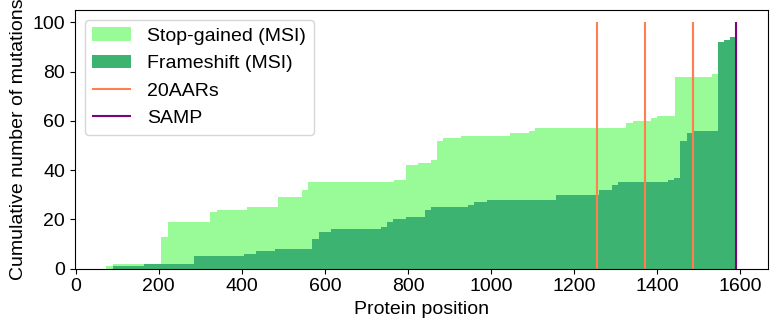

In [5]:
# Plot cumulative distribution of mutations in MSI samples

all_stops_frame_mss=all_stops_frame[all_stops_frame['#Participant_id'].isin(msi_ids)]
all_frame=all_stops_frame_mss[all_stops_frame_mss['Type']=='frameshift']
all_stops=all_stops_frame_mss[all_stops_frame_mss['Type']=='stop_gained']
print('MSI samples n=', len(msi_ids), ', MSI stop-gained mutations n=',len(all_stops),' MSI frameshift mutations n=',len(all_frame))     
      

plt.figure(figsize=(8,3.5))
plt.rcParams.update({'font.size':14})
plt.rcParams['font.family']='Liberation Sans'

plt.hist(all_stops['Position'],100,cumulative=True,color='palegreen',label='Stop-gained (MSI)')
plt.hist(all_frame['Position'],100,cumulative=True,color='mediumseagreen',label='Frameshift (MSI)')

plt.vlines(1256,0,100,'coral')
plt.vlines(1370,0,100,'coral')
plt.vlines(1486,0,100,'coral')
plt.vlines(1486,0,100,'coral',label='20AARs')
plt.vlines(1589,0,100,'purple',label='SAMP')
plt.xlabel('Protein position')
plt.ylabel('Cumulative number of mutations')
plt.legend()
plt.tight_layout()

plt.savefig('APC_muts_msi.svg',dpi=300)

cmis,bmis=np.histogram(all_stops['Position'],100)
cmif,bmif=np.histogram(all_frame['Position'],100)

POLE samples n= 364 , POLE stop-gained mutations n= 36  POLE frameshift mutations n= 0


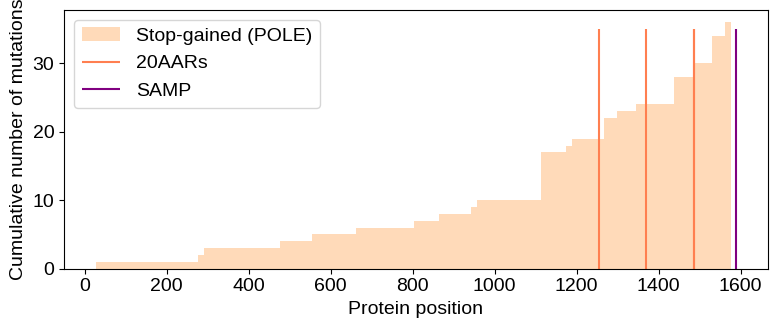

In [6]:
# Plot cumulative distribution of mutations in POLE samples

all_stops_frame_mss=all_stops_frame[all_stops_frame['#Participant_id'].isin(pole_ids)]
all_frame=all_stops_frame_mss[all_stops_frame_mss['Type']=='frameshift']
all_stops=all_stops_frame_mss[all_stops_frame_mss['Type']=='stop_gained']
print('POLE samples n=', len(msi_ids), ', POLE stop-gained mutations n=',len(all_stops),' POLE frameshift mutations n=',len(all_frame))     
      
plt.figure(figsize=(8,3.5))
plt.rcParams.update({'font.size':14})
plt.rcParams['font.family']='Liberation Sans'#({'font.size':14})

plt.hist(all_stops['Position'],100,cumulative=True,color='peachpuff',label='Stop-gained (POLE)')

plt.vlines(1256,0,35,'coral')
plt.vlines(1370,0,35,'coral')
plt.vlines(1486,0,35,'coral')
plt.vlines(1486,0,35,'coral',label='20AARs')
plt.vlines(1589,0,35,'purple',label='SAMP')
plt.xlabel('Protein position')
plt.ylabel('Cumulative number of mutations')
plt.legend()
plt.tight_layout()

plt.savefig('APC_muts_pole.svg',dpi=300)


nn,cp=np.histogram(all_stops['Position'],100)

In [7]:
data=pd.DataFrame(data={'MSS-stopgained':cmss,'Bins1':bmss[0:-1] ,'MSS-frameshifts':cmsf,'Bins2':bmsf[0:-1],'POLE-stopgained':nn,'Bins3':cp[0:-1] ,'MSI-stopgained':cmis,'Bins4':bmis[0:-1] ,'MSI-frameshifts':cmif,'Bins5':bmif[0:-1]})

In [8]:
data.to_csv('APC_distribution.csv')